2024-12-11 02:24:07.240552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733883847.258951 2232969 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733883847.263821 2232969 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 02:24:07.286871: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180371 entries, 0 to 180370
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 180371 non-null  int64  
 1   dur                180371 non-null  float64
 2   proto              180371 non-null  object 
 3   service            180371 non-null  object 
 4   state              180371 non-null  object 
 5   spkts              180371 non-null  int64  
 6   dpkts              180371 non-null  int64  
 7   sbytes             180371 non-null  int64  
 8   dbytes             180371 non-null  int64  
 9   rate               180371 non-null  float64
 10  sttl               180371 non-null  int64  
 11  dttl               180371 non-null  int64  
 12  sload              180371 non-null  float64
 13  dload              180371 non-null  float64
 14  sloss              180371 non-null  int64  
 15  dloss              180371 non-null  

/tmp/ipykernel_2232969/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


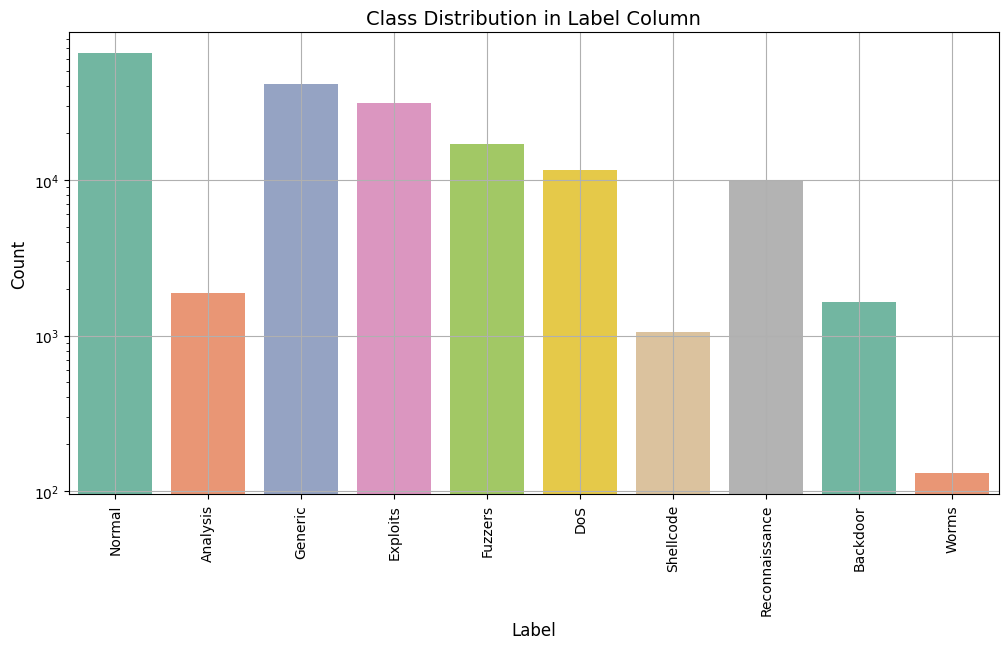

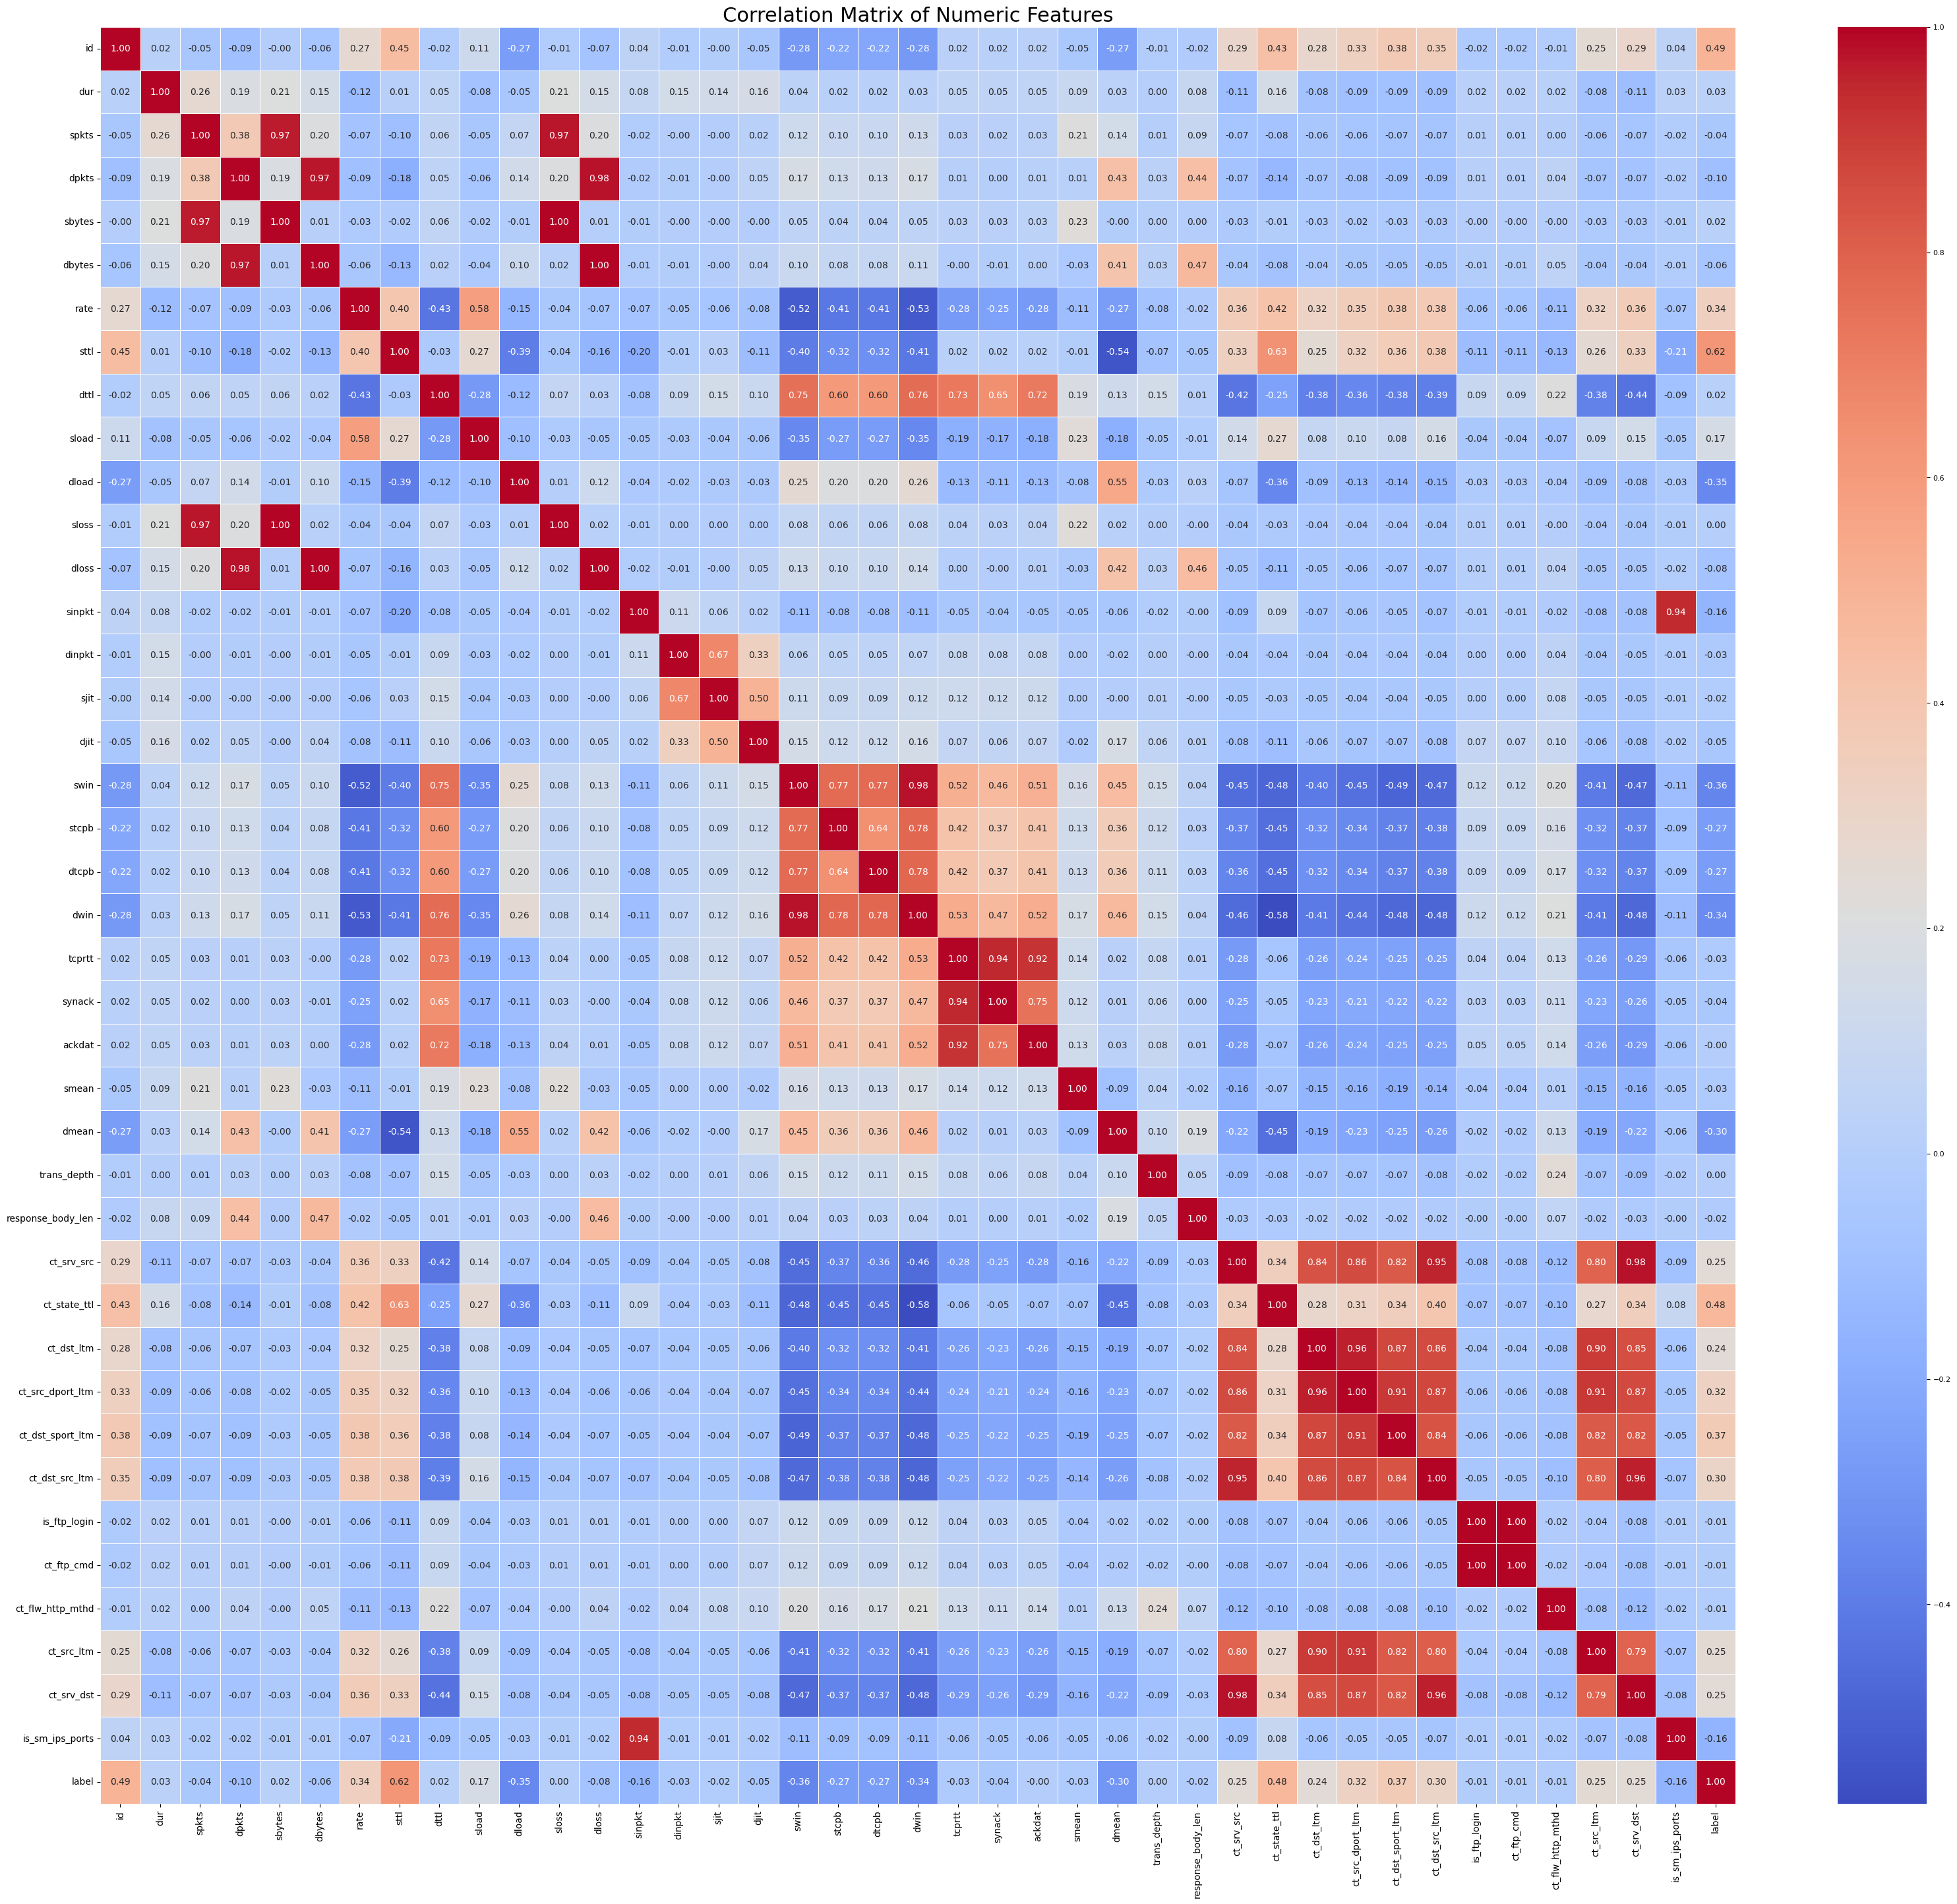

In [1]:
import import_ipynb
%run UNSW_NB15_data_preprocessing.ipynb

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Save reports
output_dir = r"./report/"
os.makedirs(output_dir, exist_ok=True)

# Traditional statistical methods
def t_test(X_train, X_val, y_train, y_val):
    t_stat, p_value = stats.ttest_ind(y_train, y_val)
    return p_value

def anova(X_train, X_val, y_train, y_val):
    f_stat, p_value = stats.f_oneway(y_train, y_val)
    return p_value

def linear_regression(X_train, X_val, y_train, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

def multiple_regression(X_train, X_val, y_train, y_val):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse

def f_test(X_train, X_val, y_train, y_val):
    model1 = LinearRegression().fit(X_train, y_train)
    model2 = LinearRegression().fit(X_val, y_val)
    rss1 = np.sum((y_train - model1.predict(X_train)) ** 2)
    rss2 = np.sum((y_val - model2.predict(X_val)) ** 2)
    f_stat = (rss1 - rss2) / rss2
    p_value = 1 - stats.f.cdf(f_stat, len(X_train) - 1, len(X_val) - 1)
    return p_value

def mann_whitney_u(X_train, X_val, y_train, y_val):
    u_stat, p_value = stats.mannwhitneyu(y_train, y_val)
    return p_value

def pca(X_train, X_val, y_train, y_val):
    # Apply PCA and return the explained variance ratio
    pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    return pca.explained_variance_ratio_

def tsne(X_train, X_val, y_train, y_val):
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    X_train_tsne = tsne.fit_transform(X_train)
    X_val_tsne = tsne.fit_transform(X_val)
    return X_train_tsne, X_val_tsne

# List of traditional statistical methods
methods = {
    't-test': t_test,
    'ANOVA': anova,
    'Linear Regression': linear_regression,
    'Multiple Regression': multiple_regression,
    'F-Test': f_test,
    'Mann-Whitney U Test': mann_whitney_u,
    'PCA': pca,
    't-SNE': tsne
}

# Store evaluation results for each method
results = []

# Standardize the data before applying PCA and t-SNE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train and evaluate each statistical method on the validation set
for name, method in methods.items():
    if name in ['Linear Regression', 'Multiple Regression']:
        # Apply linear regression and calculate mean squared error (MSE)
        mse = method(X_train_scaled, X_val_scaled, y_train, y_val)
        results.append({
            'Model': name,
            'Validation MSE': mse
        })
    elif name in ['PCA', 't-SNE']:
        # Apply PCA or t-SNE for dimensionality reduction and report explained variance
        if name == 'PCA':
            explained_variance = method(X_train_scaled, X_val_scaled, y_train, y_val)
            results.append({
                'Model': name,
                'Explained Variance Ratio': explained_variance
            })
        elif name == 't-SNE':
            # t-SNE returns transformed data; we'll just note this operation
            method(X_train_scaled, X_val_scaled, y_train, y_val)
            results.append({
                'Model': name,
                'Data after t-SNE': 'Transformed'
            })
    else:
        # Apply t-test, ANOVA, F-Test, Mann-Whitney U Test on the validation set
        p_value = method(X_train_scaled, X_val_scaled, y_train, y_val)
        results.append({
            'Model': name,
            'P-Value': p_value
        })

# Display the evaluation results
results_df = pd.DataFrame(results)
print("Model Evaluation on Validation Set:")
print(results_df)

# Save the validation set results
results_file = os.path.join(output_dir, 'statistical_method_validation_results.csv')
results_df.to_csv(results_file, index=False)
print(f"Validation set results saved to {results_file}")


Model Evaluation on Validation Set:
                 Model   P-Value  Validation MSE  \
0               t-test  0.770497             NaN   
1                ANOVA  0.770497             NaN   
2    Linear Regression       NaN    1.169322e-29   
3  Multiple Regression       NaN    1.169322e-29   
4               F-Test  1.000000             NaN   
5  Mann-Whitney U Test  0.593665             NaN   
6                  PCA       NaN             NaN   
7                t-SNE       NaN             NaN   

                     Explained Variance Ratio Data after t-SNE  
0                                         NaN              NaN  
1                                         NaN              NaN  
2                                         NaN              NaN  
3                                         NaN              NaN  
4                                         NaN              NaN  
5                                         NaN              NaN  
6  [0.27218334224889384, 0.1123255625474

In [3]:
import pandas as pd
import os

results_df['Set'] = 'Validation'

print("\nCombined Results for Statistical Methods:")
print(results_df)

combined_results_file = os.path.join(output_dir, 'combined_statistical_method_results.csv')
results_df.to_csv(combined_results_file, index=False)
print(f"Combined results saved to {combined_results_file}")



Combined Results for Statistical Methods:
                 Model   P-Value  Validation MSE  \
0               t-test  0.770497             NaN   
1                ANOVA  0.770497             NaN   
2    Linear Regression       NaN    1.169322e-29   
3  Multiple Regression       NaN    1.169322e-29   
4               F-Test  1.000000             NaN   
5  Mann-Whitney U Test  0.593665             NaN   
6                  PCA       NaN             NaN   
7                t-SNE       NaN             NaN   

                     Explained Variance Ratio Data after t-SNE         Set  
0                                         NaN              NaN  Validation  
1                                         NaN              NaN  Validation  
2                                         NaN              NaN  Validation  
3                                         NaN              NaN  Validation  
4                                         NaN              NaN  Validation  
5                         

Explained Variance Ratio: [2.72183342e-01 1.12325563e-01 8.94836845e-02 8.43589434e-02
 6.94943758e-02 5.84442295e-02 4.36496603e-02 3.85501480e-02
 2.83964036e-02 2.72155685e-02 2.33117032e-02 2.16983588e-02
 2.07914631e-02 1.96509660e-02 1.55402334e-02 1.14863108e-02
 1.05248885e-02 1.04578916e-02 9.74759888e-03 9.25194323e-03
 6.92499323e-03 4.55913803e-03 4.37944676e-03 2.58769339e-03
 1.50333489e-03 1.24969040e-03 7.87616158e-04 5.49143838e-04
 3.70678000e-04 2.44365345e-04 1.77019481e-04 4.67145771e-05
 2.97449504e-05 2.71449499e-05]


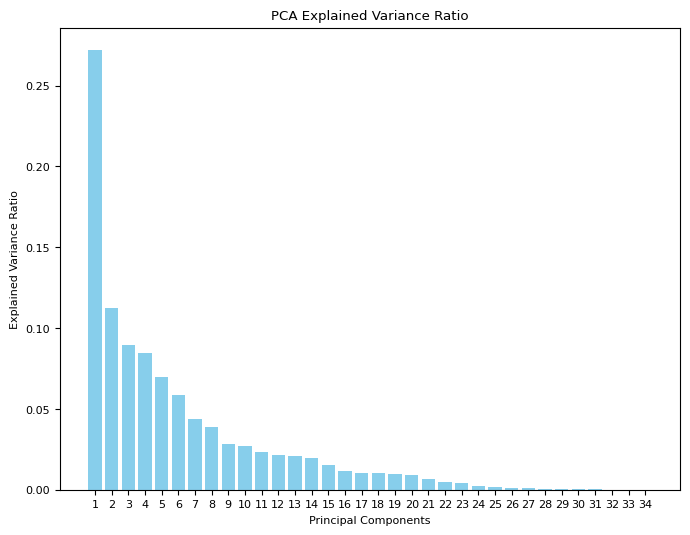

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca(X_train, X_val, y_train, y_val, n_components=None):
    if n_components is None:
        n_components = min(X_train.shape[1], X_val.shape[1])
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    return pca.explained_variance_ratio_

explained_variance = pca(X_train_scaled, X_val_scaled, y_train, y_val)

print("Explained Variance Ratio:", explained_variance)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
plt.axhline(0, color='black',linewidth=0.5)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()


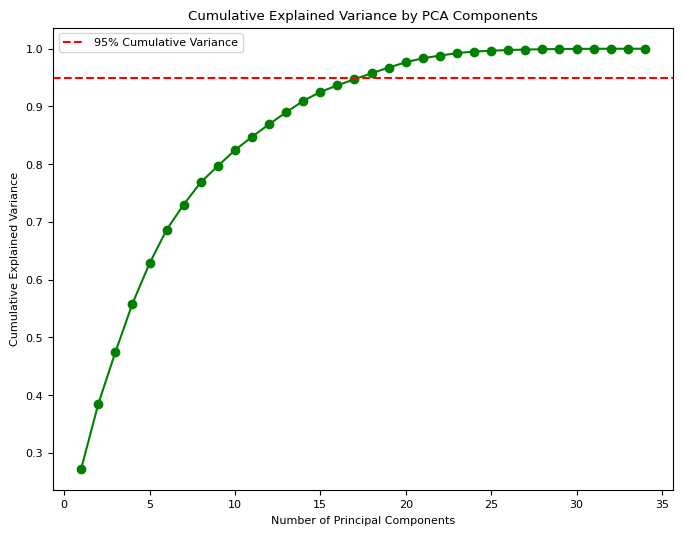

In [5]:
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='green', marker='o')
plt.axhline(0.95, color='red', linestyle='--', label='95% Cumulative Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.legend()
plt.show()


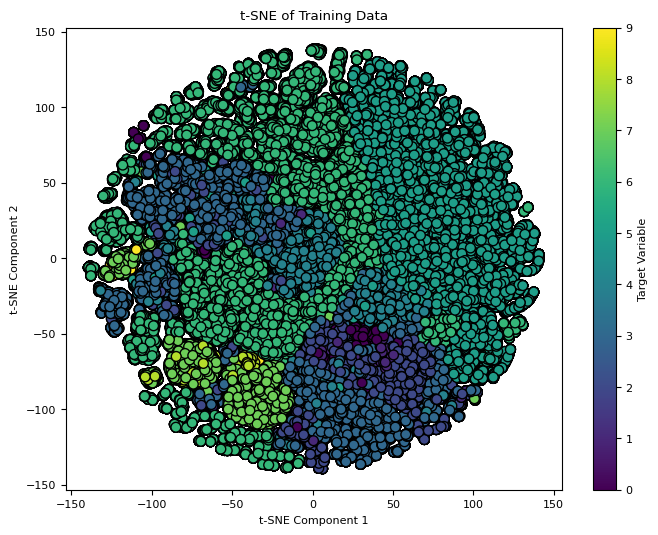

In [6]:
X_train_tsne, X_val_tsne = tsne(X_train_scaled, X_val_scaled, y_train, y_val)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title("t-SNE of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label='Target Variable')
plt.show()


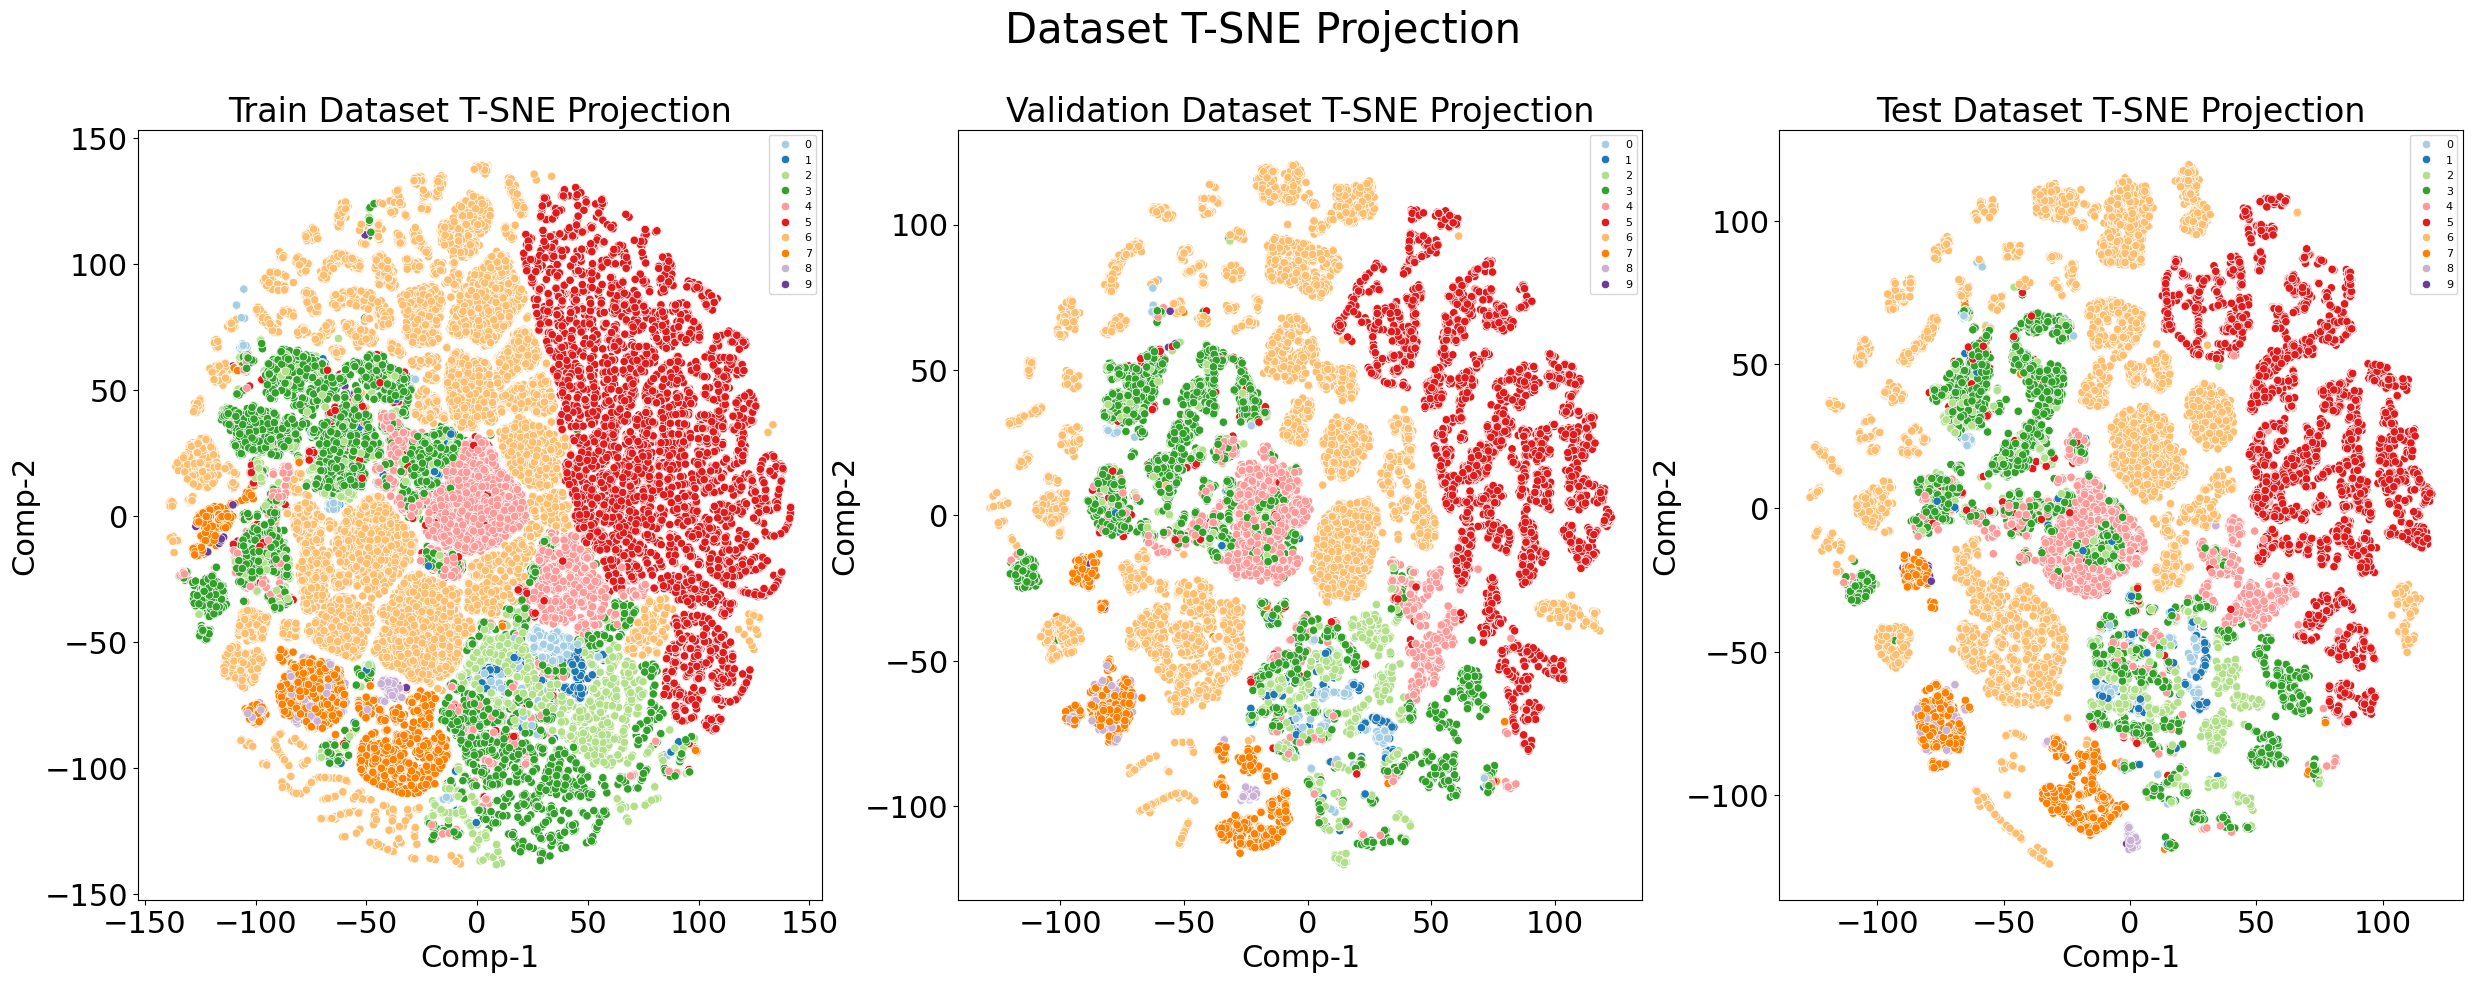

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def TSNE_visualizer(X):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(X)

t_sne_train = TSNE_visualizer(np.array(X_train, dtype='float'))
t_sne_val = TSNE_visualizer(np.array(X_val, dtype='float'))
t_sne_test = TSNE_visualizer(np.array(X_test, dtype='float'))

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

titles = ["Train", "Validation", "Test"]
c = [y_train, y_val, y_test]

for i in range(3):
    ax = axes[i]
    t_sne_data = [t_sne_train, t_sne_val, t_sne_test][i]
    sns.scatterplot(x=t_sne_data[:, 0], y=t_sne_data[:, 1], hue=c[i], ax=ax, palette="Paired")
    ax.set_title(f"{titles[i]} Dataset T-SNE Projection", fontsize=24)
    ax.set_xlabel('Comp-1', fontsize=22)
    ax.set_ylabel('Comp-2', fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=22)

plt.suptitle('Dataset T-SNE Projection', size=30, y=1.0)
plt.savefig("Dataset_T_SNE_Projection.png")
plt.show()
